In [1]:
import numpy as np
import pandas as pd
import warnings
import itertools
import random
import gc
import os
from copy import deepcopy
from tqdm.notebook import tqdm
from pathlib import Path
from dataclasses import dataclass, field
from matplotlib import pyplot as plt
import seaborn as sns
import wandb
from dataclasses import asdict

sns.set()

warnings.simplefilter("ignore")

In [7]:
rootdir = Path().resolve().parent
inputdir = rootdir / "data" / "predict-ai-model-runtime"
node_feat_dir = rootdir / "data" / "google-slow-vs-fast-layout-7-85"
trans_node_feat_dir = rootdir / "data" / "google-slow-vs-fastlayout6-92-dataset"
trans_node_config_feat_dir = rootdir / "data" / "google-slow-vs-fastlayout7-81-dataset"
workdir = Path().resolve() / "out"
workdir.mkdir(exist_ok=True, parents=True)

In [8]:
dataset_dict = {}
ignores = []
for ds in ["train", "valid", "test"]:
    records = []
    for arch, perm in itertools.product(["nlp", "xla"], ["default", "random"]):
        datadir = inputdir / f"npz_all/npz/layout/{arch}/{perm}/{ds}"
        for filepath in sorted(datadir.glob("*.npz")):
            filename = str(filepath).split("/")[-1].replace(".npz", "")

            if (ds != "test") and (("mlperf" in filename) or ("openai" in filename)):
                ignores.append(filepath)
                continue
            records.append(
                {
                    "arch": arch,
                    "perm": perm,
                    "filename": filename,
                    "filepath": filepath,
                    "node_feat_filepath": str(
                        node_feat_dir / arch / perm / ds / f"{filename}.npz"
                    ),
                    "trans_node_feat_filepath": str(
                        trans_node_feat_dir
                        / "layout"
                        / arch
                        / perm
                        / ds
                        / f"{filename}.npz"
                    ),
                    "trans_node_config_filepath": str(
                        trans_node_config_feat_dir
                        / arch
                        / perm
                        / ds
                        / f"{filename}.npz"
                    ),
                }
            )
    dataset_dict[ds] = pd.DataFrame(records)

In [11]:
dftrain = dataset_dict["train"]
dft = dftrain.query(f"filename == 'mask_rcnn_batch_4_bf16_img1408'")
dft

,arch,perm,filename,filepath,node_feat_filepath,trans_node_feat_filepath,trans_node_config_filepath
420,xla,default,mask_rcnn_batch_4_bf16_img1408,/home/yamaguchi/kaggle/data/predict-ai-model-r...,/home/yamaguchi/kaggle/data/google-slow-vs-fas...,/home/yamaguchi/kaggle/data/google-slow-vs-fas...,/home/yamaguchi/kaggle/data/google-slow-vs-fas...
470,xla,random,mask_rcnn_batch_4_bf16_img1408,/home/yamaguchi/kaggle/data/predict-ai-model-r...,/home/yamaguchi/kaggle/data/google-slow-vs-fas...,/home/yamaguchi/kaggle/data/google-slow-vs-fas...,/home/yamaguchi/kaggle/data/google-slow-vs-fas...


In [16]:
rts = []
for _, row in dft.iterrows():
    file = np.load(row["filepath"])
    rt = file["config_runtime"]
    rts.append(rt / rt.min())

<Axes: >

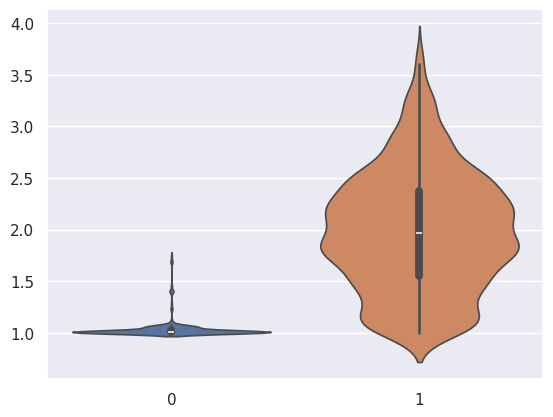

In [17]:
sns.violinplot(rts)